## benchmarking on sushmita ROY's dataset


In [1]:
from scprint import scPrint
from scdataloader import Preprocessor
from scprint.tasks import GRNfer

from bengrn import BenGRN, get_sroy_gt, unnormalize
import scanpy as sc
from bengrn.base import train_classifier

from anndata.utils import make_index_unique
from bengrn import compute_genie3
from grnndata import utils as grnutils
import numpy as np
import joblib

%load_ext autoreload
%autoreload 2 

import torch
torch.set_float32_matmul_precision('medium')

💡 connected lamindb: jkobject/scprint


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/umap/__init__.py:9: ImportWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn(


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/chex/_src/pytypes.py:53: DeprecationWarning: jax.core.Shape is deprecated. Use Shape = Sequence[int | Any].
  Shape = jax.core.Shape


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/chex/_src/pytypes.py:54: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime detection of typed prng keys (i.e. keys created with jax.random.key).
For more information, see https://jax.readthedocs.io/en/latest/jep/9263-typed-keys.html
  PRNGKey = jax.random.KeyArray


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scib_metrics/_types.py:9: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime detection of typed prng keys (i.e. keys created with jax.random.key).
For more information, see https://jax.readthedocs.io/en/latest/jep/9263-typed-keys.html
  IntOrKey = Union[int, jax.random.KeyArray]


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scib_metrics/utils/_utils.py:40: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime detection of typed prng keys (i.e. keys created with jax.random.key).
For more information, see https://jax.readthedocs.io/en/latest/jep/9263-typed-keys.html
  def validate_seed(seed: IntOrKey) -> jax.random.KeyArray:


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scib_metrics/utils/_kmeans.py:21: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime detection of typed prng keys (i.e. keys created with jax.random.key).
For more information, see https://jax.readthedocs.io/en/latest/jep/9263-typed-keys.html
  def _initialize_random(X: jnp.ndarray, n_clusters: int, key: jax.random.KeyArray) -> jnp.ndarray:


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scib_metrics/utils/_kmeans.py:31: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime detection of typed prng keys (i.e. keys created with jax.random.key).
For more information, see https://jax.readthedocs.io/en/latest/jep/9263-typed-keys.html
  def _initialize_plus_plus(X: jnp.ndarray, n_clusters: int, key: jax.random.KeyArray) -> jnp.ndarray:


In [2]:
# '../../data/main/gene_embeddings.parquet')
MAXGENES = 5000
MAXCELLS = 1024
model = scPrint.load_from_checkpoint(
    '../data/temp/o2uniqsx/epoch=18-step=133000.ckpt', precpt_gene_emb=None, )#organisms=['NCBITaxon:9606','NCBITaxon:10090'])
metrics = {}


RuntimeError caught: scPrint is not attached to a `Trainer`.

In [3]:
preprocessor = Preprocessor(is_symbol=True, force_preprocess=True, skip_validate=True,do_postp=False, min_valid_genes_id=MAXGENES, min_dataset_size=64)

# han / human

In [4]:
preadata = get_sroy_gt(get="han", species="human", gt="full")
adata = preprocessor(preadata.copy())
adata.var["isTF"] = False
adata.var.loc[adata.var.symbol.isin(grnutils.TF), "isTF"] = True
preadata, (preadata.grn.sum(1) != 0).sum()

Dropping layers: 

KeysView(Layers with keys: )

checking raw counts

removed 0 non primary cells, 5520 renamining

filtered out 0 cells, 5520 renamining

Removed 0 genes.

startin QC

Seeing 151 outliers (2.74% of total dataset):

done

(GRnnData object with n_obs × n_vars = 5520 × 7465
     obs: 'organism_ontology_term_id'
     varp: 'GRN'
     with a grn of 8463 elements,
 31)

In [5]:
grn_inferer = GRNfer(model, adata,
                     how="most var within",
                     genes=adata.var[adata.var.symbol.isin(preadata.var[preadata.grn.sum(1) != 0].index.tolist())].index.tolist(),
                     preprocess="softmax",
                     head_agg='none',
                     filtration="none",
                     forward_mode="none",
                     organisms=['NCBITaxon:9606','NCBITaxon:10090'],
                     apc=False,
                     symmetrize=False,
                     num_genes=MAXGENES,
                     max_cells=MAXCELLS,
                     doplot=False,
                     batch_size=32,
                     )
grn = grn_inferer(layer=list(range(model.nlayers))[:])

Using 16bit Automatic Mixed Precision (AMP)


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


number of expressed genes in this cell type: 7295

/home/ml4ig1/Documents code/scPRINT/scprint/tasks/grn.py:165: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=[subadata.obs['organism_ontology_term_id'][0]],


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  ) < LooseVersion("1.15"):


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [6]:
grn.varp["all"] = grn.varp['GRN']
grn.var['ensembl_id'] = grn.var.index
grn.var['symbol'] = make_index_unique(grn.var['symbol'].astype(str))
grn.var.index = grn.var['symbol']

precision: 

0.038948387096774194


recall: 

1.0


random precision:

0.03895617833244068

  0%|                                         | 0/128 [00:00<?, ?it/s]

 62%|███████████████████▍           | 80/128 [00:00<00:00, 797.24it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()


100%|██████████████████████████████| 128/128 [00:00<00:00, 847.43it/s]

Area Under Precision-Recall Curve (AUPRC): 

0.0695345532881509

EPR:

2.978185129033612

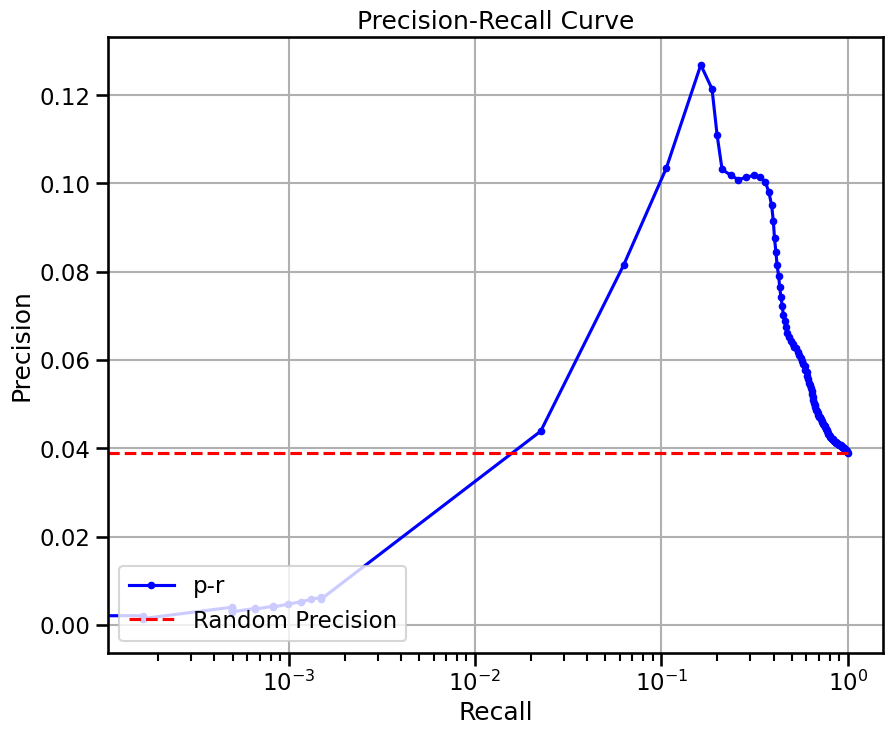

In [7]:
grn.varp['GRN'] = grn.varp['all'].mean(-1).T
metrics['scprint_mean_han_full'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

base enrichment

Top central genes:

[]

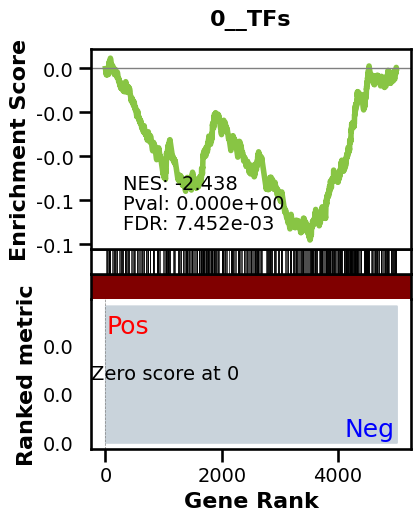

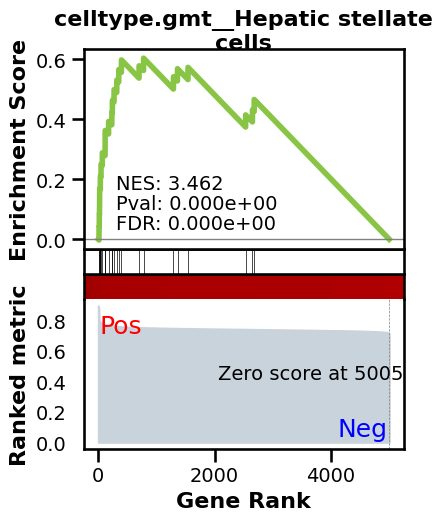

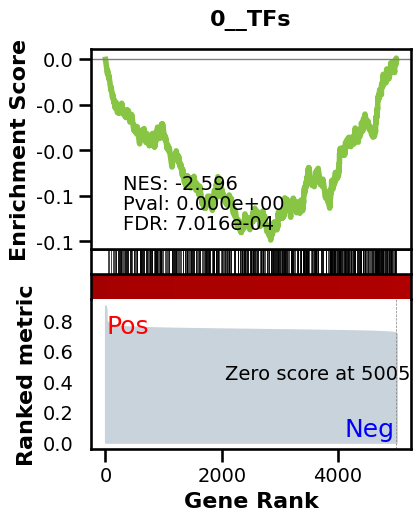

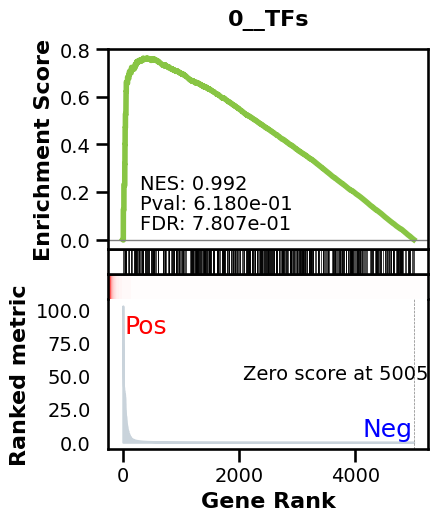

_________________________________________

TF specific enrichment

found some significant results for 

25.454545454545453

% TFs


_________________________________________

loading GT, 

omnipath

intersection of 3767 genes

intersection pct:

0.7524970035956852

precision: 

0.0016151890916386552


recall: 

1.0


random precision:

0.001615617978811156

  0%|                                             | 0/128 [00:00<?, ?it/s]

  4%|█▍                                   | 5/128 [00:00<00:02, 43.80it/s]

  8%|██▊                                 | 10/128 [00:00<00:02, 43.76it/s]

 12%|████▏                               | 15/128 [00:00<00:02, 43.05it/s]

 16%|█████▋                              | 20/128 [00:00<00:02, 42.37it/s]

 20%|███████                             | 25/128 [00:00<00:02, 41.97it/s]

 23%|████████▍                           | 30/128 [00:00<00:02, 41.88it/s]

 27%|█████████▊                          | 35/128 [00:00<00:02, 41.95it/s]

 31%|███████████▎                        | 40/128 [00:00<00:02, 42.56it/s]

 35%|████████████▋                       | 45/128 [00:01<00:01, 42.84it/s]

 39%|██████████████                      | 50/128 [00:01<00:01, 42.46it/s]

 43%|███████████████▍                    | 55/128 [00:01<00:01, 41.54it/s]

 47%|████████████████▉                   | 60/128 [00:01<00:01, 41.40it/s]

 51%|██████████████████▎                 | 65/128 [00:01<00:01, 41.08it/s]

 55%|███████████████████▋                | 70/128 [00:01<00:01, 40.60it/s]

 59%|█████████████████████               | 75/128 [00:01<00:01, 40.19it/s]

 62%|██████████████████████▌             | 80/128 [00:01<00:01, 39.27it/s]

 66%|███████████████████████▋            | 84/128 [00:02<00:01, 38.75it/s]

 70%|█████████████████████████           | 89/128 [00:02<00:00, 39.26it/s]

 73%|██████████████████████████▍         | 94/128 [00:02<00:00, 39.96it/s]

 77%|███████████████████████████▊        | 99/128 [00:02<00:00, 40.21it/s]

 81%|████████████████████████████▍      | 104/128 [00:02<00:00, 37.22it/s]

 84%|█████████████████████████████▌     | 108/128 [00:02<00:00, 35.65it/s]

 88%|██████████████████████████████▉    | 113/128 [00:02<00:00, 37.78it/s]

 92%|████████████████████████████████▎  | 118/128 [00:02<00:00, 39.22it/s]

 95%|█████████████████████████████████▎ | 122/128 [00:03<00:00, 39.21it/s]

 99%|██████████████████████████████████▋| 127/128 [00:03<00:00, 40.47it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()


100%|███████████████████████████████████| 128/128 [00:03<00:00, 40.40it/s]

Area Under Precision-Recall Curve (AUPRC): 

0.001805727737594386

EPR:

2.0321305173018605

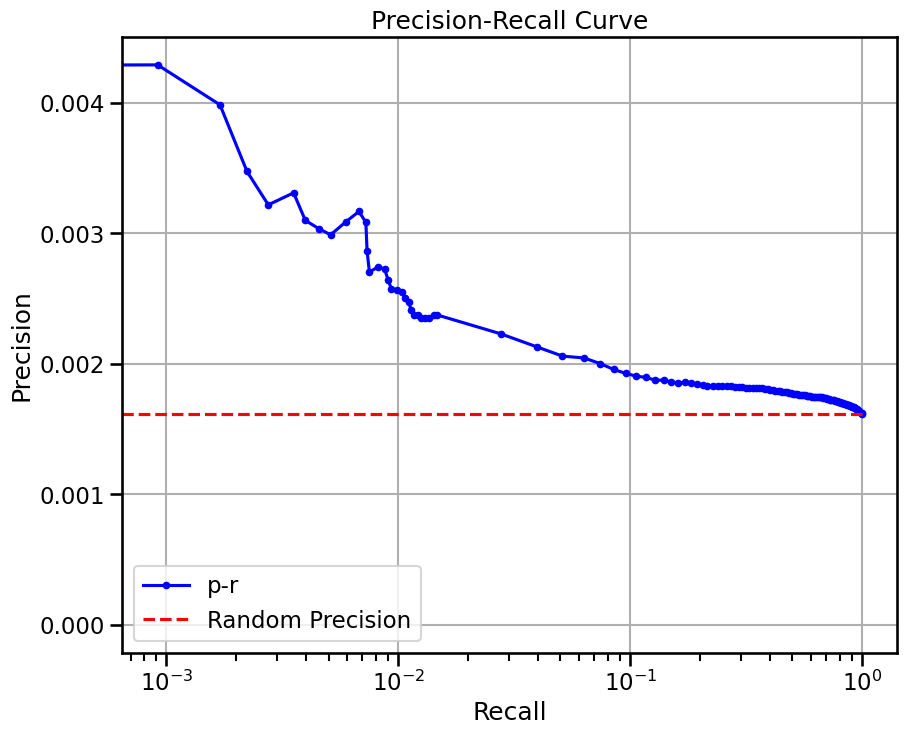

In [8]:
grn.varp['GRN'] = grn.varp['GRN'].T
metrics['scprint_mean_han_base'] = BenGRN(grn, do_auc=True, doplot=True).scprint_benchmark()

precision: 

0.264192


recall: 

1.0


random precision:

0.26424484896979394

  0%|                                             | 0/128 [00:00<?, ?it/s]

 30%|██████████▋                        | 39/128 [00:00<00:00, 383.29it/s]

 71%|████████████████████████▉          | 91/128 [00:00<00:00, 458.99it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()


100%|██████████████████████████████████| 128/128 [00:00<00:00, 458.02it/s]

Area Under Precision-Recall Curve (AUPRC): 

0.2946465490902279

EPR:

1.1545093654468563

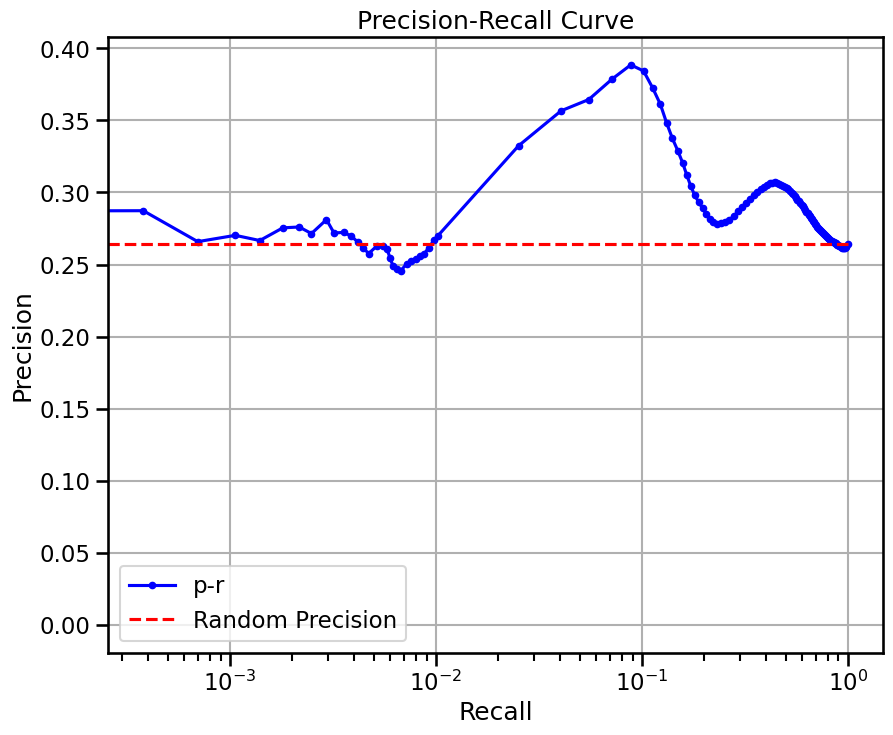

In [9]:
preadata = get_sroy_gt(get="han", species="human", gt="chip")
grn.varp['GRN'] = grn.varp['GRN'].T
metrics['scprint_mean_han_chip'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

precision: 

0.08270819672131148


recall: 

1.0


random precision:

0.0827247416696454

  0%|                                             | 0/128 [00:00<?, ?it/s]

 29%|██████████                         | 37/128 [00:00<00:00, 366.82it/s]

 61%|█████████████████████▎             | 78/128 [00:00<00:00, 389.54it/s]

 93%|███████████████████████████████▌  | 119/128 [00:00<00:00, 395.77it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()


100%|██████████████████████████████████| 128/128 [00:00<00:00, 389.64it/s]

Area Under Precision-Recall Curve (AUPRC): 

0.09642713636120592

EPR:

1.9393293614430762

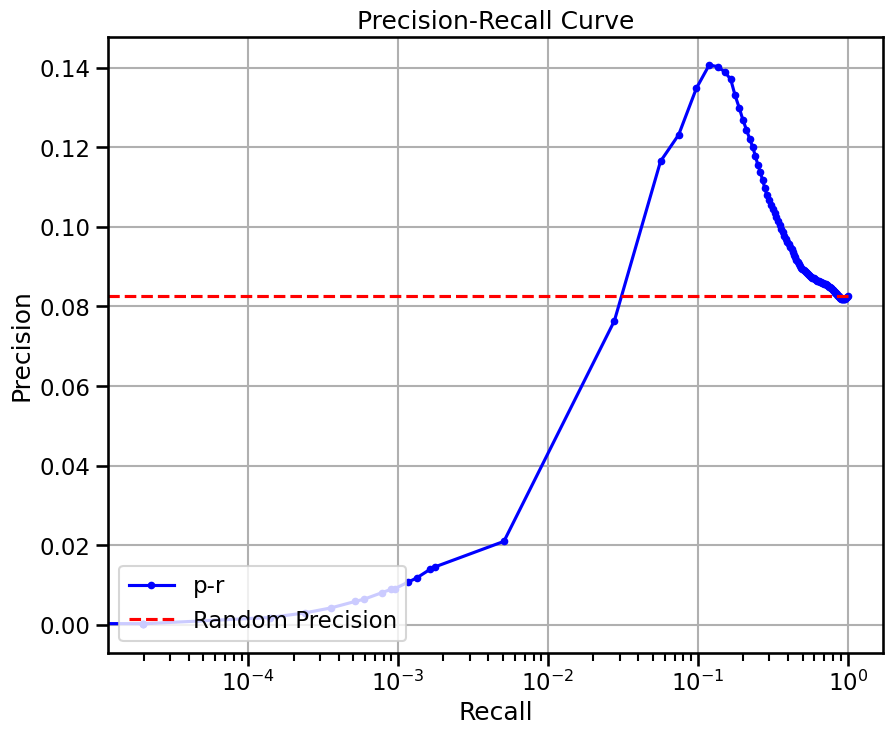

In [10]:
preadata = get_sroy_gt(get="han", species="human", gt="ko")
metrics['scprint_mean_han_ko'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

In [11]:
preadata = get_sroy_gt(get="han", species="human", gt="full")

In [ ]:
grn.varp["GRN"] = grn.varp['all']
grn, m, clf_omni = train_classifier(grn, C=0.1, train_size=0.9, class_weight={1: 200, 0: 1}, shuffle=True)

In [ ]:
# Save the clf_omni classifier to a file
joblib.dump(clf_omni, 'clf_omni_model.pkl')

In [ ]:
grn.varp['GRN'] = grn.varp['classified'].T
metrics['scprint_omni_han_full'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

In [ ]:
grn.varp['GRN'] = grn.varp['classified']
metrics['scprint_omni_han_base'] = BenGRN(grn, do_auc=True, doplot=True).scprint_benchmark()

In [ ]:
preadata = get_sroy_gt(get="han", species="human", gt="chip")
metrics['scprint_omni_han_chip'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

In [ ]:
preadata = get_sroy_gt(get="han", species="human", gt="ko")
metrics['scprint_omni_han_ko'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

In [ ]:
grn.varp['GRN'] = np.transpose(grn.varp['all'], (1,0,2))
weight = int((preadata.grn.sum(1)>0).sum()* (preadata.grn.sum(0)>0).sum()/ preadata.grn.sum().sum())
grn, m, clf_self = train_classifier(
    grn, other=preadata, C=0.1, train_size=0.5, class_weight={1: weight, 0: 1}, shuffle=True, max_iter=500,)
grn.varp['GRN'] = grn.varp['classified']
metrics['scprint_self_han_full'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

In [ ]:
joblib.dump(clf_self, 'clf_self_model.pkl')

In [ ]:
grn.varp['GRN'] = grn.varp['classified'].T
metrics['scprint_self_han_base'] = BenGRN(grn, do_auc=True, doplot=True).scprint_benchmark()

In [ ]:
grn.varp['GRN'] = grn.varp['classified']
preadata = get_sroy_gt(get="han", species="human", gt="chip")
metrics['scprint_self_han_chip'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

In [ ]:
preadata = get_sroy_gt(get="han", species="human", gt="ko")
metrics['scprint_self_han_ko'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

In [ ]:
del grn

# mine / human

In [ ]:
preadata = get_sroy_gt(get="mine", species="human", gt="full")
adata = preprocessor(preadata.copy())
adata.var["isTF"] = False
adata.var.loc[adata.var.symbol.isin(grnutils.TF), "isTF"] = True
preadata, (preadata.grn.sum(1) != 0).sum()

In [ ]:
grn_inferer = GRNfer(model, adata,
                     how="most var within",
                     genes=adata.var[adata.var.symbol.isin(preadata.var[preadata.grn.sum(1) != 0].index.tolist())].index.tolist(),
                     preprocess="softmax",
                     head_agg='none',
                     filtration="none",
                     forward_mode="none",
                     organisms=['NCBITaxon:9606','NCBITaxon:10090'],
                     apc=False,
                     symmetrize=False,
                     num_genes=MAXGENES,
                     max_cells=MAXCELLS,
                     doplot=False,
                     batch_size=32,
                     )
grn = grn_inferer(layer=list(range(model.nlayers))[:])

In [ ]:
grn.varp["all"] = grn.varp['GRN']
grn.var['ensembl_id'] = grn.var.index
grn.var['symbol'] = make_index_unique(grn.var['symbol'].astype(str))
grn.var.index = grn.var['symbol']

In [ ]:
grn.varp['GRN'] = grn.varp['all'].mean(-1).T
metrics['scprint_mean_mine_full'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

In [ ]:
grn.varp['GRN'] = grn.varp['all'].mean(-1)
metrics['scprint_mean_mine_base'] = BenGRN(grn, do_auc=True, doplot=True).scprint_benchmark()

In [ ]:
grn.varp["GRN"] = clf_omni.predict_proba(
    grn.varp['all'].reshape(-1, grn.varp['all'].shape[-1])
).reshape(len(grn.var), len(grn.var), 2)[:, :, 1].T
metrics['scprint_omni_mine_full'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

In [ ]:
grn.varp["GRN"] = grn.varp["GRN"].T
metrics['scprint_omni_mine_base'] = BenGRN(grn, do_auc=True, doplot=True).scprint_benchmark()

In [ ]:
grn.varp["GRN"] = clf_self.predict_proba(
    grn.varp['all'].reshape(-1, grn.varp['all'].shape[-1])
).reshape(len(grn.var), len(grn.var), 2)[:, :, 1].T
metrics['scprint_omni_mine_full'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

In [ ]:
grn.varp['GRN'] = grn.varp['GRN'].T
metrics['scprint_omni_mine_base'] = BenGRN(grn, do_auc=True, doplot=True).scprint_benchmark()

In [ ]:
del grn

In [ ]:
metrics

## tran / mouse

In [ ]:
preadata = get_sroy_gt(get="tran", species="mouse", gt="full")
adata = preprocessor(preadata.copy())
adata.var["isTF"] = False
adata.var.loc[adata.var.symbol.isin(grnutils.TF), "isTF"] = True
preadata, (preadata.grn.sum(1) != 0).sum()

In [ ]:
grn_inferer = GRNfer(model, adata,
                     how="most var within",
                     genes=adata.var[adata.var.symbol.isin(preadata.var[preadata.grn.sum(1) != 0].index.tolist())].index.tolist(),
                     preprocess="softmax",
                     head_agg='none',
                     filtration="none",
                     forward_mode="none",
                     organisms=['NCBITaxon:9606','NCBITaxon:10090'],
                     apc=False,
                     symmetrize=False,
                     num_genes=MAXGENES,
                     max_cells=MAXCELLS,
                     doplot=False,
                     batch_size=32,
                     )
grn = grn_inferer(layer=list(range(model.nlayers))[:])

In [ ]:
grn.varp["all"] = grn.varp['GRN']
grn.var['ensembl_id'] = grn.var.index
grn.var['symbol'] = make_index_unique(grn.var['symbol'].astype(str))
grn.var.index = grn.var['symbol']

In [ ]:
grn.varp['GRN'] = grn.varp['all'].mean(-1).T
metrics['scprint_mean_han_full'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

In [ ]:
preadata = get_sroy_gt(get="tran", species="mouse", gt="chip")
metrics['scprint_mean_han_chip'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

In [ ]:
preadata = get_sroy_gt(get="tran", species="mouse", gt="ko")
metrics['scprint_mean_han_ko'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

In [ ]:
preadata = get_sroy_gt(get="tran", species="mouse", gt="full")

In [ ]:
grn.varp["GRN"] = clf_omni.predict_proba(
    grn.varp['all'].reshape(-1, grn.varp['all'].shape[-1])
).reshape(len(grn.var), len(grn.var), 2)[:, :, 1].T
metrics['scprint_omni_tran_full'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

In [ ]:
preadata = get_sroy_gt(get="tran", species="mouse", gt="chip")
metrics['scprint_omni_tran_chip'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

In [ ]:
preadata = get_sroy_gt(get="tran", species="mouse", gt="ko")
metrics['scprint_omni_tran_ko'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

In [ ]:
preadata = get_sroy_gt(get="tran", species="mouse", gt="full")
grn.varp["GRN"] = clf_self.predict_proba(
    grn.varp['all'].reshape(-1, grn.varp['all'].shape[-1])
).reshape(len(grn.var), len(grn.var), 2)[:, :, 1].T
metrics['scprint_self_tran_full'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

In [ ]:
preadata = get_sroy_gt(get="tran", species="mouse", gt="chip")
metrics['scprint_self_tranan_chip'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

In [ ]:
preadata = get_sroy_gt(get="tran", species="mouse", gt="ko")
metrics['scprint_self_tran_ko'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

In [ ]:
del grn

## zhao / mouse

In [ ]:
preadata = get_sroy_gt(get="zhao", species="mouse", gt="full")
adata = preprocessor(preadata.copy())
adata.var["isTF"] = False
adata.var.loc[adata.var.symbol.isin(grnutils.TF), "isTF"] = True
preadata, (preadata.grn.sum(1) != 0).sum()

In [ ]:
grn_inferer = GRNfer(model, adata,
                     how="most var within",
                     genes=adata.var[adata.var.symbol.isin(preadata.var[preadata.grn.sum(1) != 0].index.tolist())].index.tolist(),
                     preprocess="softmax",
                     head_agg='none',
                     filtration="none",
                     forward_mode="none",
                     organisms=['NCBITaxon:9606','NCBITaxon:10090'],
                     apc=False,
                     symmetrize=False,
                     num_genes=MAXGENES,
                     max_cells=MAXCELLS,
                     doplot=False,
                     batch_size=32,
                     )
grn = grn_inferer(layer=list(range(model.nlayers))[:])

In [ ]:
grn.varp["all"] = grn.varp['GRN']
grn.var['ensembl_id'] = grn.var.index
grn.var['symbol'] = make_index_unique(grn.var['symbol'].astype(str))
grn.var.index = grn.var['symbol']

In [ ]:
grn.varp['GRN'] = grn.varp['all'].mean(-1).T
metrics['scprint_mean_han_full'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

In [ ]:
grn.varp["GRN"] = clf_omni.predict_proba(
    grn.varp['all'].reshape(-1, grn.varp['all'].shape[-1])
).reshape(len(grn.var), len(grn.var), 2)[:, :, 1].T
metrics['scprint_omni_tran_full'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

In [ ]:
preadata = get_sroy_gt(get="tran", species="mouse", gt="full")
grn.varp["GRN"] = clf_self.predict_proba(
    grn.varp['all'].reshape(-1, grn.varp['all'].shape[-1])
).reshape(len(grn.var), len(grn.var), 2)[:, :, 1].T
metrics['scprint_self_tran_full'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

In [ ]:
metrics